# Linear Regression for predicting the purchase value of a player
In this notebook we will train a linear regression to create a model capable of predicting the purchase value of a player.

For this we can use a dataset called TFM_Transfers.csv that contains the purchase value and other variables for multiple players.

In [ ]:
import pandas as pd
import sys
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from datetime import datetime

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


We start by opening the csv with pandas and then filter the fields that I found most relevant to the problem.

In [ ]:
market_dataset = pd.read_csv("TFM_Transfers.csv")

# nº direct goal contributions 
market_dataset['goal_contributions_T'] = market_dataset['assists_T'] \
 + market_dataset['goals_T']

market_dataset = market_dataset[['position','weight', 'height','foot','Age',\
'Market_Value','Buyer_Country','competition','win_%','Nationality', \
'Seller','Buyer', 'Seller_Country', 'Transfer_Price',\
'goal_contributions_T','minutesOnField_T']]

A country's **GDP per capita** tells us a lot about a country's external economy by comparing it to other countries. As such, it could be an interesting indicator for the model since the economy of a country also has a lot of influence on the financial power of clubs in that country.

Here, both the GDP per capita of the country of the buying club and the GDP of the buying club are of interest, since the financial situations of both parties involved will influence the transfer values practiced.
We will then resort to the following datasets **pib_seller.xlsx** and **pib_buyer.xlsx**.

**Information on datasets related to GDP per capita**

In [ ]:
pib_seller = pd.read_excel("pib_seller.xlsx")
pib_seller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Seller_Country                 196 non-null    object
 1   GDP per capita Seller Country  196 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [ ]:
pib_seller.head()

,Seller_Country,GDP per capita Seller Country
0,Luxemburgo,125923
1,Irlanda,90478
2,Suiza,90358
3,Noruega,76408
4,Estados Unidos,66144


In [ ]:
pib_seller.describe()

,GDP per capita Seller Country
count,196.000000
mean,14870.290816
std,20096.901373
min,267.000000
25%,2190.000000
50%,5523.000000
75%,20080.750000
max,125923.000000


In [ ]:
pib_buyer = pd.read_excel("pib_buyer.xlsx")
pib_buyer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Buyer_Country                 200 non-null    object
 1   GDP per capita Buyer Country  200 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [ ]:
pib_buyer.tail()

,Buyer_Country,GDP per capita Buyer Country
195,Gales,24586
196,China,9020
197,Catar,62100
198,Kazajistán,10003
199,Mónaco,190512


In [ ]:
pib_buyer.describe()

,GDP per capita Buyer Country
count,200.000000
mean,15931.060000
std,23688.852767
min,267.000000
25%,2255.500000
50%,5936.000000
75%,20576.250000
max,190512.000000


**Add to the initial dataset the GDP's per capita of the countries**

In [ ]:
market_dataset = pd.merge(market_dataset,pib_buyer[["Buyer_Country","GDP \
per capita Buyer Country"]], on ="Buyer_Country", how = "outer")
market_dataset = pd.merge(market_dataset,pib_seller[['Seller_Country','GDP \
per capita Seller Country']], on ="Seller_Country", how = "outer")

**Delete duplicates**

In [ ]:
market_dataset = market_dataset.drop_duplicates()

**Delete rows and columns with NA**

In [ ]:
market_dataset = market_dataset.dropna(how='any')

**Information about dataset market_dataset**

In [ ]:
market_dataset.shape

(266, 18)

In [ ]:
market_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 0 to 270
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   position                       266 non-null    object 
 1   weight                         266 non-null    float64
 2   height                         266 non-null    float64
 3   foot                           266 non-null    object 
 4   Age                            266 non-null    float64
 5   Market_Value                   266 non-null    float64
 6   Buyer_Country                  266 non-null    object 
 7   competition                    266 non-null    object 
 8   win_%                          266 non-null    float64
 9   Nationality                    266 non-null    object 
 10  Seller                         266 non-null    object 
 11  Buyer                          266 non-null    object 
 12  Seller_Country                 266 non-null    obj

In [ ]:
market_dataset.isnull().sum()

position                         0
weight                           0
height                           0
foot                             0
Age                              0
Market_Value                     0
Buyer_Country                    0
competition                      0
win_%                            0
Nationality                      0
Seller                           0
Buyer                            0
Seller_Country                   0
Transfer_Price                   0
goal_contributions_T             0
minutesOnField_T                 0
GDP per capita Buyer Country     0
GDP per capita Seller Country    0
dtype: int64

In [ ]:
market_dataset.nunique()

position                           4
weight                            35
height                            34
foot                               3
Age                               20
Market_Value                      62
Buyer_Country                     49
competition                       66
win_%                             64
Nationality                       69
Seller                           213
Buyer                            204
Seller_Country                    48
Transfer_Price                   119
goal_contributions_T              20
minutesOnField_T                 235
GDP per capita Buyer Country      49
GDP per capita Seller Country     48
dtype: int64

**Best foot distribution**

In [ ]:
market_dataset['foot'].unique()

array(['left', 'right', 'both'], dtype=object)

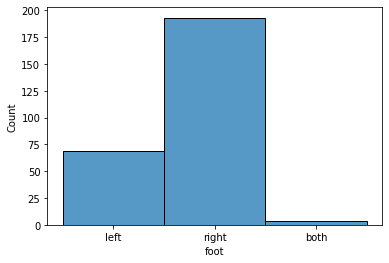

In [ ]:
sns.histplot(data = market_dataset,x ='foot')

**remove ambidextrous players from the dataset**

In [ ]:
market_dataset = market_dataset[market_dataset['foot'].isin(['right','left'])]

**Minimum, Maximum, Mean, Standard Deviation, Quantiles of numerical variables**

In [ ]:
market_dataset.describe()[1:]

,weight,height,Age,Market_Value,win_%,Transfer_Price,goal_contributions_T,minutesOnField_T,GDP per capita Buyer Country,GDP per capita Seller Country
mean,73.595420,177.729008,24.660305,4.082920e+06,38.818702,4.063935e+06,2.221374,693.568702,31428.530534,27869.087786
std,11.485309,23.255021,3.731797,7.779614e+06,28.799377,6.721214e+06,3.665705,675.241692,27873.325196,19964.694645
min,0.000000,0.000000,16.000000,5.000000e+04,0.000000,5.000000e+04,0.000000,20.000000,3380.000000,1586.000000
25%,70.000000,175.000000,22.000000,6.000000e+05,20.000000,4.000000e+05,0.000000,192.500000,9095.000000,9095.000000
50%,74.000000,180.500000,24.000000,1.200000e+06,39.000000,1.000000e+06,1.000000,382.500000,30432.000000,25991.000000
75%,79.000000,185.000000,27.000000,4.000000e+06,52.475000,4.500000e+06,3.000000,1219.500000,42236.000000,42236.000000
max,95.000000,198.000000,36.000000,6.000000e+07,100.000000,5.500000e+07,22.000000,2603.000000,190512.000000,90358.000000


**Obviously there cannot be players with a minimum weight and height of 0**, so these players are **Outliers** and therefore we are removing them.
Let's start by looking at the distribution of the weight and height variables.

**Weight distribution**

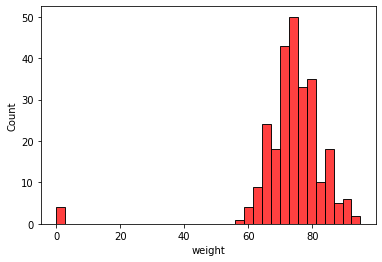

In [ ]:
sns.histplot(data = market_dataset,x = 'weight',color = "red")

**Height distribution**

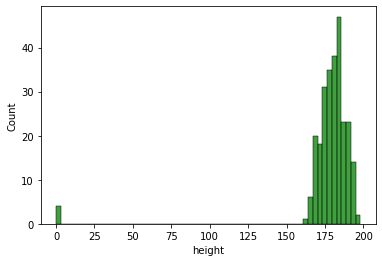

In [ ]:
sns.histplot(data=market_dataset,x = 'height',color="green")

**Remove the outliers related with weight and height.**

In [ ]:
market_dataset = market_dataset[(market_dataset['height'] > 0) \
                          & (market_dataset['weight'] > 0)]

**Quantify the impact de uma variable in the other variable through a correlation heatmap**

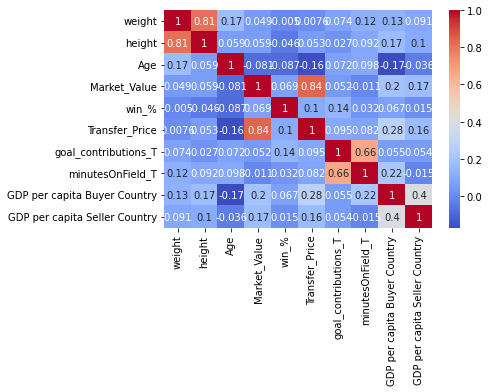

In [ ]:
sns.heatmap(market_dataset.corr(), annot=True,cmap = "coolwarm")

**Age distribution**

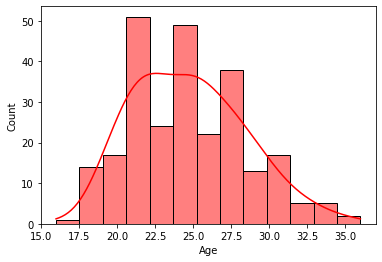

In [ ]:
sns.histplot(data = market_dataset,x ='Age',kde = "True",color = "red")

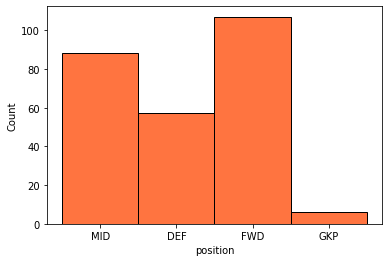

In [ ]:
sns.histplot(data = market_dataset,x = 'position',color = "orangered")

**GDP per capita distribution**

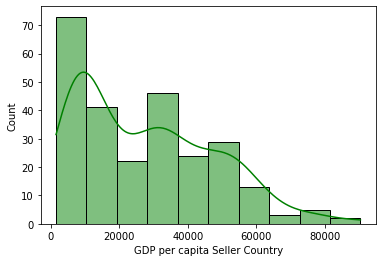

In [ ]:
sns.histplot(data=market_dataset,x ='GDP per capita Seller Country', \
kde="True",color="green")

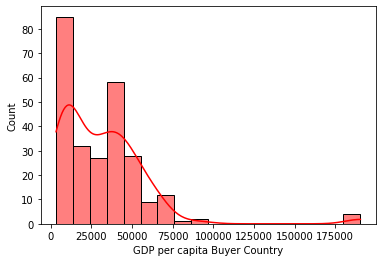

In [ ]:
sns.histplot(data=market_dataset,x ='GDP per capita Buyer Country', \
kde="True",color="red")

In [ ]:
market_dataset[market_dataset['GDP per capita Buyer Country'] \
               > 150000]['Buyer_Country']

84     Mónaco
119    Mónaco
176    Mónaco
177    Mónaco
Name: Buyer_Country, dtype: object

**Monaco** is an Outlier in terms of GDP per capita and as so I'm removing from the dataset the rows and columns that have Monaco as a buyer country/club.

In [ ]:
market_dataset = market_dataset[market_dataset['GDP per capita Buyer Country'] \
                                < 150000]

**features distribution**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17559088d0>,
      dtype=object)

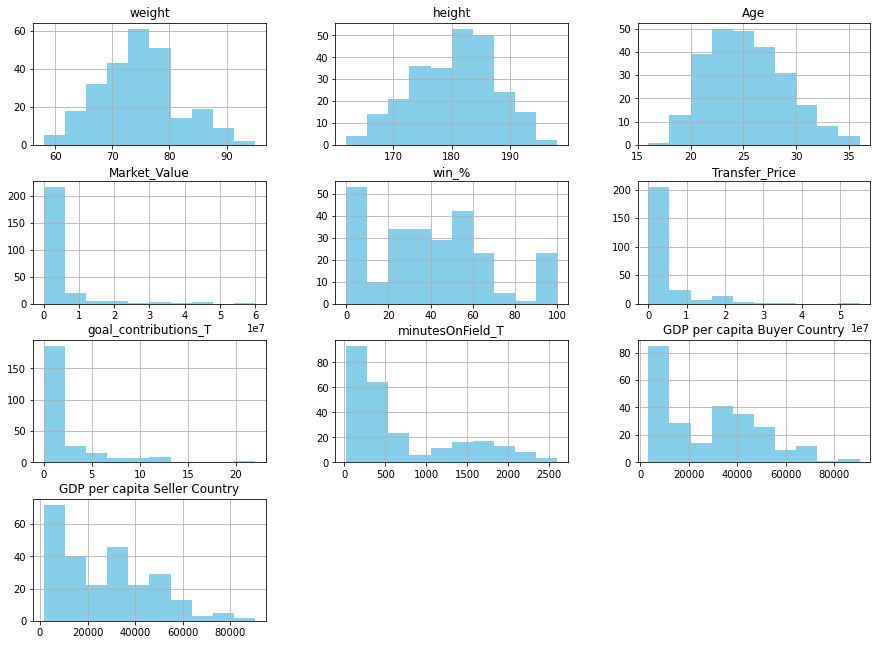

In [ ]:
market_dataset.hist(figsize = (15,11),color = 'skyblue')

**Extremes and Quartiles Diagram**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

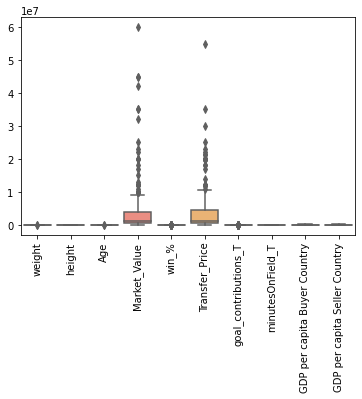

In [ ]:
sns.boxplot(data = market_dataset,palette = "Set3")
plt.xticks(rotation = 90)

Here we can confirm through the catplot that the market value of players closer to the end of their careers has less amplitude and outliers, as expected.

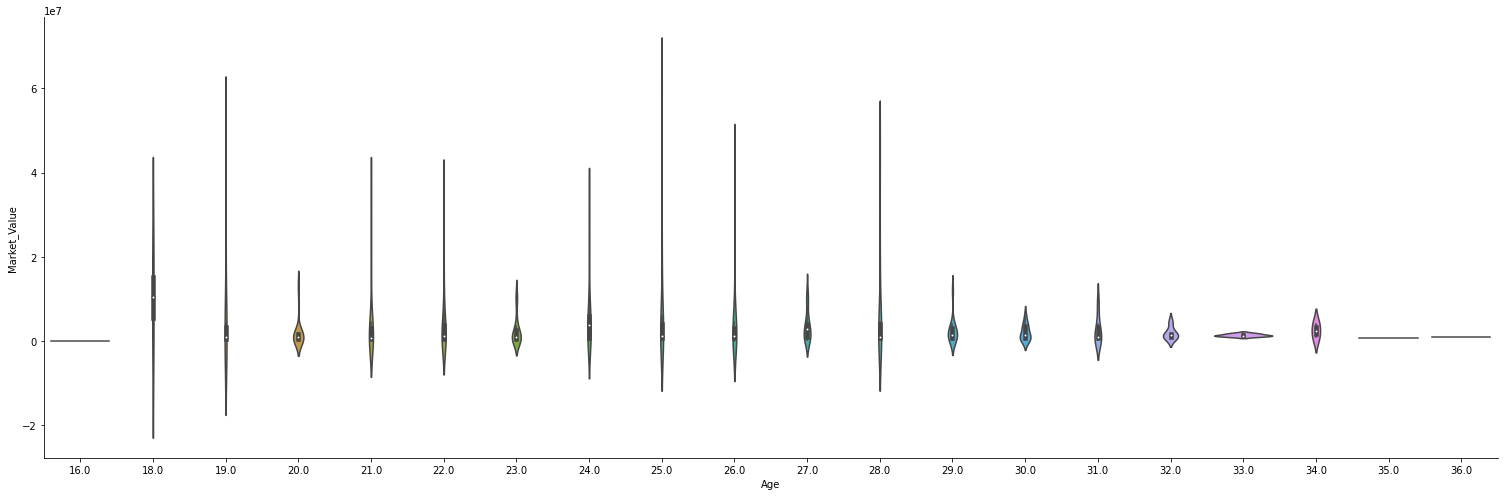

In [ ]:
sns.catplot(x = 'Age',y = 'Market_Value',kind = "violin",\
            data = market_dataset,height = 7, aspect = 3)

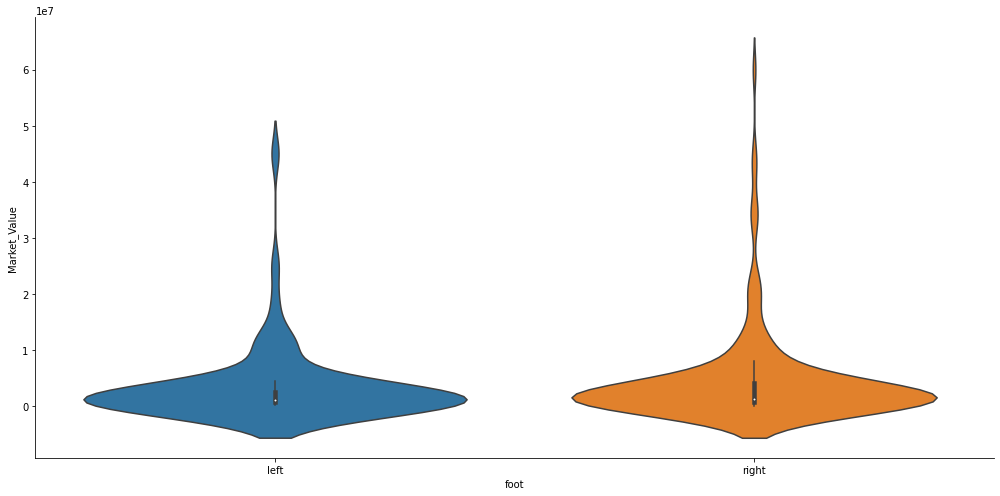

In [ ]:
sns.catplot(x = 'foot',y = 'Market_Value',kind = "violin", \
            data=market_dataset, height = 7, aspect = 2)

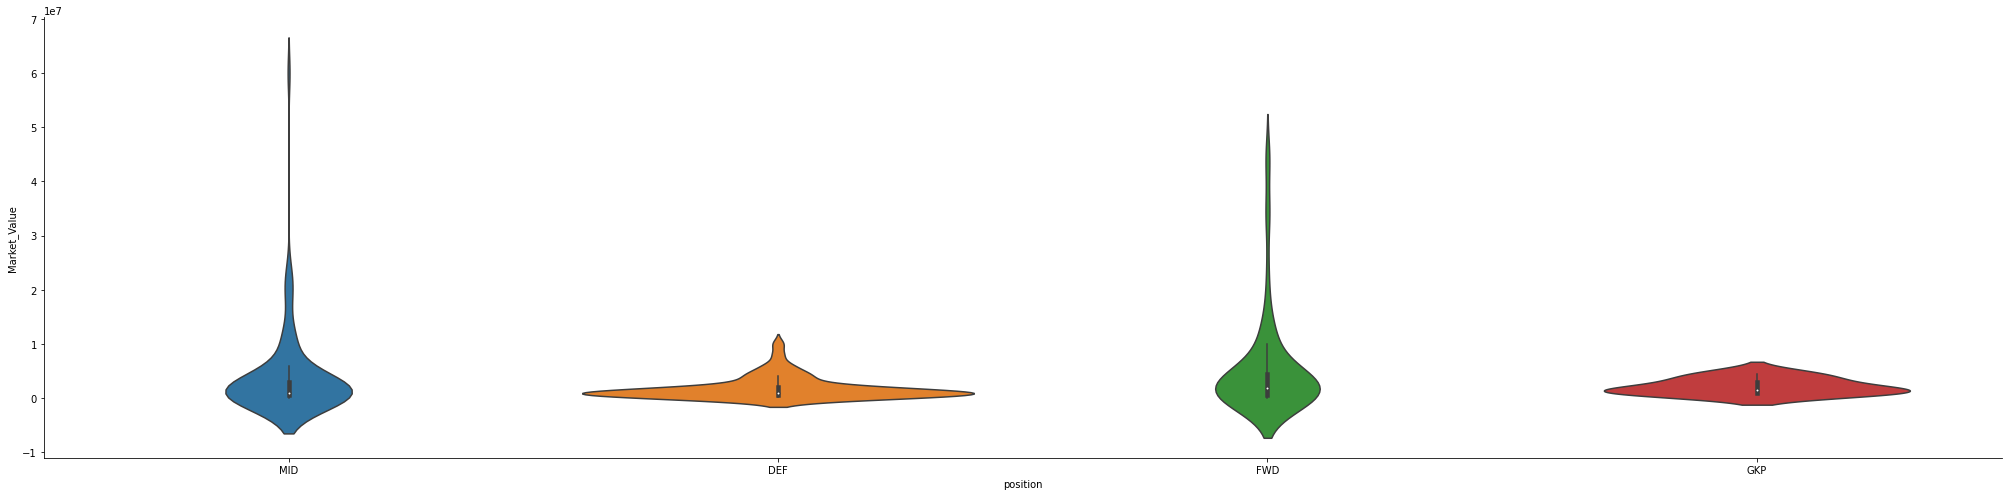

In [ ]:
sns.catplot(x = 'position',y = 'Market_Value',kind = "violin" \
            ,data = market_dataset,height = 7, aspect = 4)

As expected, the distribution of market values of Midfielders and Forwards is much less dispersed than that of GR's and Defenders and that the latter generally have much lower market values compared to Midfielders and Forwards.

**Distribution of ages at which players are sold in certain countries**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


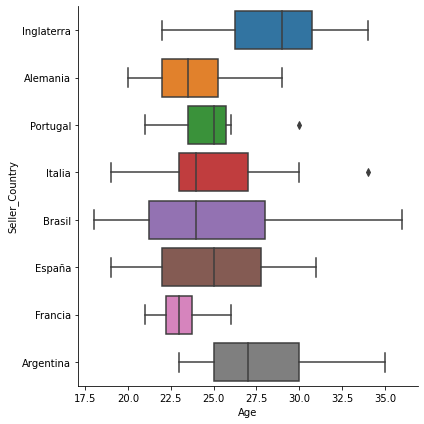

In [ ]:
sns.catplot(y = "Seller_Country" , x = "Age",kind = 'box',\
data = market_dataset[market_dataset['Seller_Country'] \
.isin(['Portugal','Brasil','España','Inglaterra', \
'Argentina','Alemania','Francia','Italia'])], size = 6)


**Curiosity:** Here we can see that Portugal is clearly a country for projecting players, which sells essentially very young players. In the other European Big-5s there is much more breadth in the distribution of ages at which players sell.

**Relationship between the sale value of a player and the value
market share estimated by Transfermarkt**

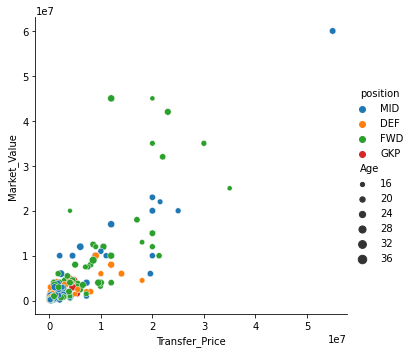

In [ ]:
sns.relplot(x = "Transfer_Price",y = "Market_Value", \
  data = market_dataset,hue = "position",size = "Age")

In [ ]:
market_dataset['dif_transf'] = \
- market_dataset['Transfer_Price'] + market_dataset['Market_Value']

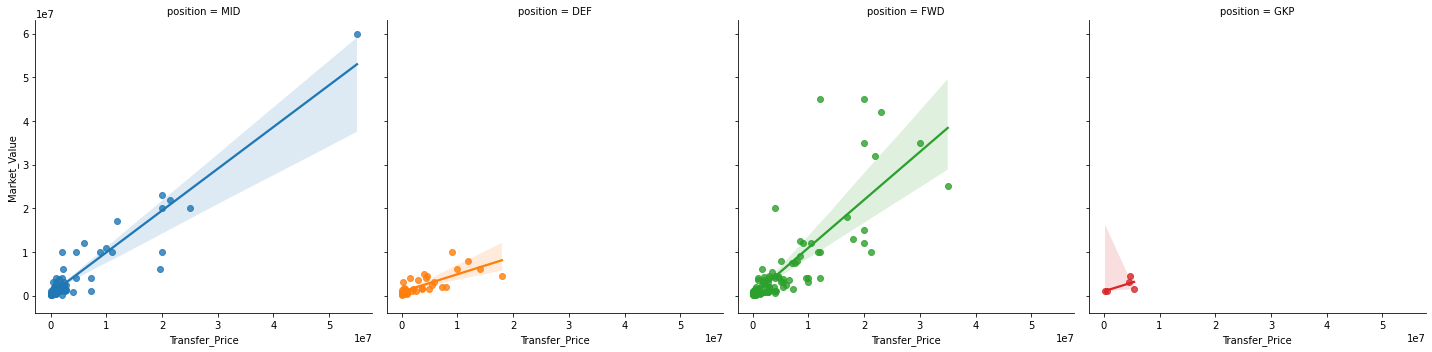

In [ ]:
sns.lmplot(x = "Transfer_Price",y = "Market_Value",data = market_dataset,col = "position",hue = 'position')

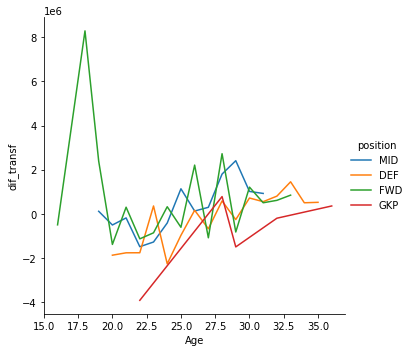

In [ ]:
sns.relplot(x = "Age",y = "dif_transf",kind = "line",\
      data = market_dataset,ci = None,hue = "position")

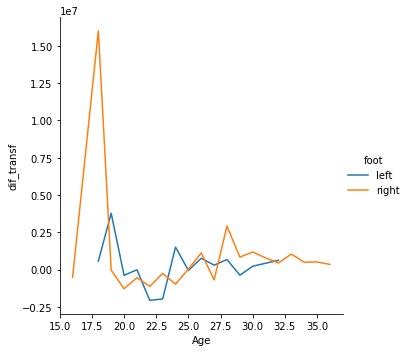

In [ ]:
sns.relplot(x = "Age",y = "dif_transf",kind = "line", \
         data = market_dataset,ci = None,hue = "foot")

From the previous graph, clubs seem more willing to pay the market value of left-handed players than of right-handed players.

Now that we have the variables we want to handle, we have to pass the categorical variables to OneHotEncoder.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

sklearn_ohe = OneHotEncoder()
cat_df = pd.DataFrame()
cat_vars = ['position','foot','Nationality', 'Seller', 'Seller_Country', \
           'Buyer_Country','competition']
for var in cat_vars:
    
  dummies = sklearn_ohe.fit_transform(market_dataset[[var]])


  column_name = list()
  for name in sklearn_ohe.categories_[0]:
    column_name.append(var + '_' + str(name))

  dummies_df = pd.DataFrame(data = dummies.toarray(), columns = column_name)
  
  cat_df = pd.concat([cat_df, dummies_df], axis = 1)


cat_df.head()

,position_DEF,position_FWD,position_GKP,position_MID,foot_left,foot_right,Nationality_Albania,Nationality_Alemania,Nationality_Argelia,Nationality_Argentina,Nationality_Armenia,Nationality_Australia,Nationality_Austria,Nationality_Bermudas,Nationality_Bosnia y Herzegovina,Nationality_Brasil,Nationality_Bulgaria,Nationality_Burkina Faso,Nationality_Bélgica,Nationality_Cabo Verde,Nationality_Canadá,Nationality_Chile,Nationality_Chipre,Nationality_Colombia,Nationality_Corea del Norte,Nationality_Costa de Marfil,Nationality_Croacia,Nationality_Dinamarca,Nationality_Ecuador,Nationality_Eslovaquia,Nationality_Eslovenia,Nationality_España,Nationality_Estonia,Nationality_Finlandia,Nationality_Francia,Nationality_Gambia,Nationality_Ghana,Nationality_Inglaterra,Nationality_Irlanda,Nationality_Irlanda del Norte,Nationality_Islandia,Nationality_Israel,Nationality_Italia,Nationality_Jamaica,Nationality_Japón,Nationality_Kirguistán,Nationality_Kosovo,Nationality_Macedonia del Norte,Nationality_Marruecos,Nationality_México,Nationality_Nigeria,Nationality_Noruega,Nationality_Panamá,Nationality_Paraguay,Nationality_Países Bajos,Nationality_Perú,Nationality_Polonia,Nationality_Portugal,Nationality_RD del Congo,Nationality_República Checa,Nationality_Rumania,Nationality_Rusia,Nationality_Senegal,Nationality_Serbia,Nationality_Suecia,Nationality_Suiza,Nationality_Tanzania,Nationality_Turquía,Nationality_Túnez,Nationality_Ucrania,Nationality_Uruguay,Nationality_Venezuela,Nationality_Zimbabue,Seller_1.FC Nürnberg,Seller_A. Malagueño,Seller_AC Horsens,Seller_AC Le Havre,Seller_AC Milan,Seller_AD Cantolao,Seller_AEL Limassol,Seller_AS Roma,Seller_Aalborg BK,Seller_Al-Ain FC,Seller_Albacete,Seller_Alianza Lima,Seller_América,Seller_Anzhi,Seller_Apol. Limassol,Seller_Arda Kardzhali,Seller_Aston Villa,Seller_Atalanta,Seller_Atl. Nacional,Seller_Atlanta United,Seller_Atlético-MG,Seller_Audax Italiano,Seller_Austria Viena,Seller_Benfica,Seller_Bodø/Glimt,Seller_Bor. Dortmund,Seller_Botafogo,Seller_Brøndby IF,Seller_Burnley,Seller_Burton Albion,Seller_CA Rosario,Seller_CA Temperley,Seller_CA Unión,Seller_CD Cruz Azul,Seller_CD Leganés,Seller_CD Palestino,Seller_CF Pachuca,Seller_Caracas FC,Seller_Cardiff,Seller_Catanzaro,Seller_Celta de Vigo,Seller_Cesena,Seller_Chapecoense,Seller_Chelsea,Seller_Chievo Verona,Seller_Chivas,Seller_Cincinnati,Seller_Club Tijuana,Seller_Colonia,Seller_Coquimbo Unido,Seller_Corinthians,Seller_Covilhã,Seller_Cruzeiro,Seller_Cukaricki,Seller_Defensa,Seller_Dep. Alavés,Seller_Deportivo Cali,Seller_Desna,Seller_Desp. Brasil,Seller_Dinamo Bucarest,Seller_Dinamo Zagreb,Seller_Dunajska Streda,Seller_Dynamo Dresden,Seller_Elche CF,Seller_Envigado,Seller_Esperance,Seller_Estrella Roja,Seller_Excelsior,Seller_FC Ashdod,Seller_FC Flora,Seller_FC Lugano,Seller_FC Metz,Seller_FC Schalke 04,Seller_FC Viitorul,Seller_FC Vysocina,Seller_FC Wil 1900,Seller_FK Dukla Praha,Seller_FK Dunav,Seller_FK Lviv,Seller_Ferroviária,Seller_Fiorentina,Seller_Fluminense,Seller_Gaz Metan,Seller_Getafe CF,Seller_Go Ahead Eagles,Seller_Greuther Fürth,Seller_Grêmio,Seller_Guayaquil City,Seller_HNK Gorica,Seller_HNK Rijeka,Seller_Hammarby,Seller_Hapoel Raanana,Seller_Hellas Verona,Seller_Huddersfield,Seller_Hull City,Seller_IK Start,Seller_Independiente,Seller_Internacional,Seller_Jagiellonia,Seller_Junior FC,Seller_Juventus U23,Seller_KAA Gent,Seller_KRC Genk,Seller_KV Kortrijk,Seller_Karpaty,Seller_Khimki,Seller_Krasnodar,Seller_Krasnodar-2,Seller_LDU Quito,Seller_Lecce,Seller_Lech Poznan,Seller_Leeds,Seller_Levante UD,Seller_Lok. Plovdiv,Seller_Ludogorets,Seller_MSK Zilina,Seller_Man City U23,Seller_Manchester Utd.,Seller_Maribor,Seller_Middlesbrough,Seller_Mladá Boleslav,Seller_Morelia,Seller_Mouscron,Seller_NK Aluminij,Seller_NK Celje,Seller_NK Osijek,Seller_NY Red Bulls,Seller_Nacional,Seller_Napredak,Seller_Nea Salamis,Seller_Necaxa,Seller_Neftekhimik,Seller_Neman Grodno,Seller_Norrköping,Seller_Odense BK,Seller_Olymp. Lyon,Seller_Olympiacos FC,Seller_PSV 

Pass the numeric variables to MinMax.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sklearn_min_max = MinMaxScaler()
num_df = pd.DataFrame()
num_vars = ['weight','height','Age','Market_Value','goal_contributions_T', \
'minutesOnField_T','GDP per capita Buyer Country','GDP per capita Seller Country'\
,'win_%']

for var in num_vars:
    
  min_max = sklearn_min_max.fit_transform(market_dataset[[var]])
  min_max_df = pd.DataFrame(data = min_max, columns = [[var]])
  
  num_df = pd.concat([num_df, min_max_df], axis = 1)


num_df.head()

,weight,height,Age,Market_Value,goal_contributions_T,minutesOnField_T,GDP per capita Buyer Country,GDP per capita Seller Country,win_%
0,0.432432,0.500000,0.50,0.024187,0.000000,0.106465,0.446734,0.599671,0.333
1,0.756757,0.694444,0.65,0.012510,0.000000,0.178862,0.446734,0.599671,0.400
2,0.270270,0.333333,0.45,0.207673,0.000000,0.022067,0.446734,0.599671,1.000
3,1.000000,0.777778,0.30,0.099249,0.000000,0.049555,0.558613,0.599671,0.500
4,0.783784,0.888889,0.15,0.749791,0.409091,0.150600,0.558613,0.599671,0.800


Join the categorical with the numerical ones in the X and separate our label column in the Y.

In [ ]:
X = pd.concat([num_df, cat_df], axis = 1)
y = market_dataset[['Transfer_Price']].values

Make the division between training dataset and test dataset.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, \
                                                    random_state=0)

print ('Conjunto de treino: %d linhas\nConjunto de teste %d linhas' \
       % (X_train.shape[0], X_test.shape[0]))

Treinamos o nosso modelos com o dataset de treino.

In [ ]:
from sklearn.linear_model import LinearRegression

# Criar um objecto de regressão linear
model = LinearRegression()
# Usar a função fit do objecto LinearRegression para treinar com os nossos dados
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


LinearRegression()

Now that we have the model trained we can use it to make predictions on the test set.

In [ ]:
predictions = model.predict(X_test)
predictions[0:5]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


array([[ 2251044.76015366],
       [ 9157019.24409687],
       [-1066900.36216985],
       [ 6104186.23557961],
       [ 4449275.8477485 ]])

Then we can use the test set predictions to evaluate our regression model.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = model.predict(X_test)


mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 23709017960233.562
RMSE: 4869190.688423853
R2: 0.5212785729062557


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


**Residplot**

A resideplot is a plot of residuals that if randomly dispersed around the horizontal axis, a linear regression model is appropriate for the data, otherwise a nonlinear model is more appropriate.

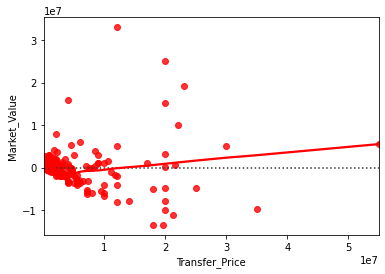

In [ ]:
sns.residplot(x = "Transfer_Price",y = "Market_Value", \
      data = market_dataset,color = 'red',lowess = True)